In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import os


In [3]:
def load_dat(path, verbose=False):
    """
    Load a .dat file into a pandas DataFrame, handling comment lines and extracting column names
    from the last commented line.
    
    Parameters:
    - path: Path to the .dat file.
    
    Returns:
    - df: pandas DataFrame containing the data.
    """
    # Read the file line by line to handle comments and column names
    with open(path, 'r') as file:
        lines = file.readlines()
    
    # Extract column names from the last line starting with '#'
    coments = [line for line in lines if line.startswith('#')]
    column_line = [line for line in lines if line.startswith('#')][-1]
    column_names = column_line.strip('#').strip().split()

    # Read the data, skipping all comment lines
    df = pd.read_csv(
        path,
        comment='#',           # Ignores all lines that begin with '#'
        delim_whitespace=True, # Split columns by whitespace
        header=None,           # No header row in the data portion
        names=column_names     # Assign column names from the last '#'
    )
    
    if verbose:
        for i in coments:
            print(i)
    return df

In [4]:
dfs = {}

for U in [240,340,440,540,640, 740]:
    df = load_dat(f'./Data/U{U}/postProcessing/forceCoeffs/0/coefficient.dat')
    dfs[U] = df

In [5]:
dfs[740]

,Time,Cd,Cd(f),Cd(r),Cl,Cl(f),Cl(r),CmPitch,CmRoll,CmYaw,Cs,Cs(f),Cs(r)
0,1,0.625940,0.312939,0.313001,-0.027794,0.011699,-0.039493,0.025596,-0.000031,0.000261,0.001133,0.000828,0.000305
1,2,0.943036,0.471488,0.471548,-0.027547,0.011696,-0.039243,0.025470,-0.000030,0.001151,0.002460,0.002381,0.000079
2,3,1.145692,0.572820,0.572872,-0.026669,0.011462,-0.038130,0.024796,-0.000026,0.001714,0.003250,0.003339,-0.000089
3,4,1.255985,0.627970,0.628015,-0.025514,0.011083,-0.036597,0.023840,-0.000022,0.002223,0.003864,0.004155,-0.000291
4,5,1.298005,0.648983,0.649022,-0.024159,0.010555,-0.034714,0.022635,-0.000019,0.002766,0.004456,0.004994,-0.000538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,0.332104,0.166035,0.166070,0.000680,0.000132,0.000548,-0.000208,-0.000017,-0.001735,-0.002275,-0.002873,0.000598
2996,2997,0.332103,0.166034,0.166069,0.000680,0.000132,0.000548,-0.000208,-0.000017,-0.001735,-0.002275,-0.002872,0.000598
2997,2998,0.332102,0.166034,0.166068,0.000680,0.000132,0.000548,-0.000208,-0.000017,-0.001735,-0.002275,-0.002872,0.000598
2998,2999,0.332101,0.166033,0.166068,0.000679,0.000132,0.000547,-0.000208,-0.000017,-0.001735,-0.002275,-0.002872,0.000598


In [6]:
dfs[240]["Cd"].iloc[-1]

0.41975894948

Text(0, 0.5, 'Cd')

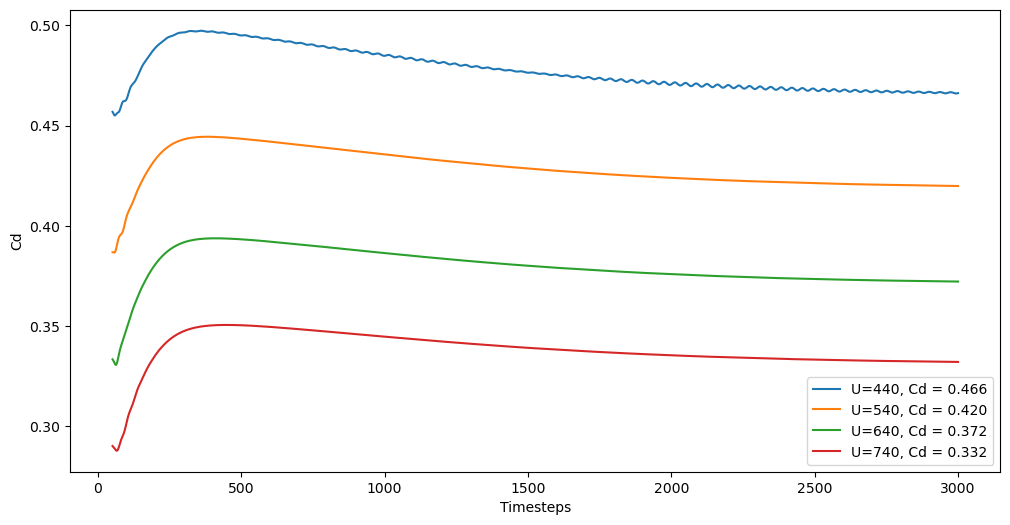

In [7]:
skip = 50

plt.figure(figsize=(12,6))

for u in [440,540,640, 740]:
    plt.plot(dfs[u]['Time'][skip:], dfs[u]['Cd'][skip:], label=f'U={u}, Cd = {dfs[u]["Cd"].iloc[-1]:.3f}')


plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Cd')

Text(0, 0.5, 'Cd')

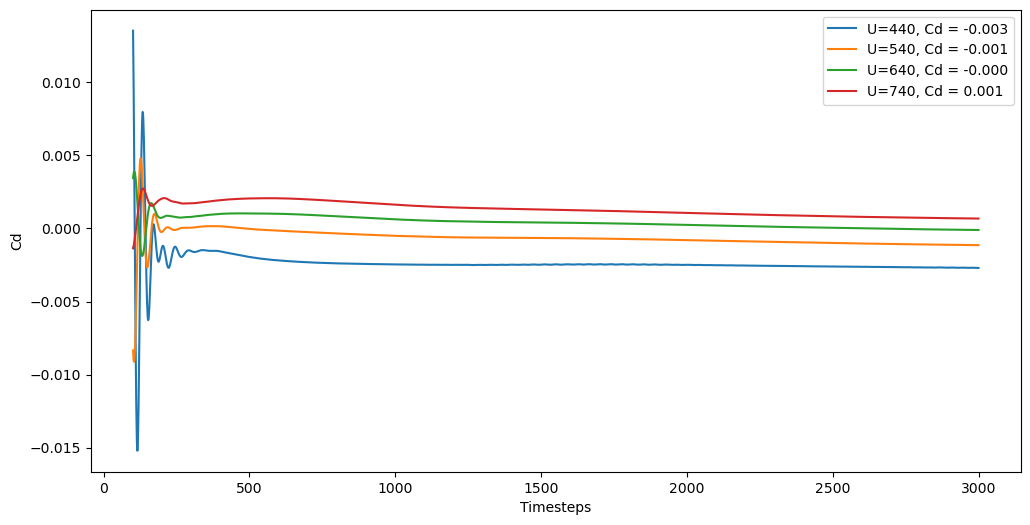

In [8]:
skip = 100
coef = 'Cl'
plt.figure(figsize=(12,6))

for u in [440,540,640, 740]:
    plt.plot(dfs[u]['Time'][skip:], dfs[u][coef][skip:], label=f'U={u}, Cd = {dfs[u][coef].iloc[-1]:.3f}')


plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Cd')

In [9]:
dfsForce = {}

for U in [240, 340, 440, 540, 640, 740]:
    dfF = load_dat(f'./Data/U{U}/postProcessing/forces/0/force.dat')
    dfM = load_dat(f'./Data/U{U}/postProcessing/forces/0/moment.dat')
    
    # Rename columns in moment DataFrame to avoid duplication
    dfF = dfF.add_prefix("force_")
    dfM = dfM.add_prefix("moment_")
    
    # Concatenate forces and moments along columns
    df = pd.concat([dfF, dfM], axis=1)

    # Initialize CoP columns
    cop_x = []
    cop_y = []
    cop_z = []
    
    varM = "total"
    varF = "total"
        # Iterate over rows to compute CoP using least-squares
    for _, row in df.iterrows():
        # Force vector
        F = np.array([row[f'force_{varF}_x'], row[f'force_{varF}_y'], row[f'force_{varF}_z']])
        
        # Moment vector
        M = np.array([row[f'moment_{varM}_x'], row[f'moment_{varM}_y'], row[f'moment_{varM}_z']])
        
        # Skip if force vector is zero
        if np.linalg.norm(F) == 0:
            cop_x.append(np.nan)
            cop_y.append(np.nan)
            cop_z.append(np.nan)
            continue
        
        # Construct skew-symmetric matrix of F
        F_cross = np.array([
            [0, F[2], -F[1]],
            [-F[2], 0, F[0]],
            [F[1], -F[0], 0]
        ])
        

        # Solve for r using least squares
        r = np.linalg.lstsq(F_cross, M, rcond=None)[0]
        
        # Append results
        cop_x.append(r[0])
        cop_y.append(r[1])
        cop_z.append(r[2])
    
    # Add CoP columns to DataFrame
    df['CoP_x'] = cop_x
    df['CoP_y'] = cop_y
    df['CoP_z'] = cop_z

    
    dfsForce[U] = df
    
    

In [12]:
dfs = {}

for U in [240,340,440,540,640, 740]:
    df = load_dat(f'./Data/U{U}/postProcessing/solverInfo/0/solverInfo.dat')
    dfs[U] = df

In [13]:
dfs[740]

,Time,U_solver,Ux_initial,Ux_final,Ux_iters,Uy_initial,Uy_final,Uy_iters,Uz_initial,Uz_final,...,omega_solver,omega_initial,omega_final,omega_iters,omega_converged,p_solver,p_initial,p_final,p_iters,p_converged
0,1,GAMG,9.999999e-01,4.749639e-08,1000,1.000000,9.325623e-11,6,1.000000,8.409696e-11,...,GAMG,9.263309e-06,5.066999e-12,3,True,DILUPBiCGStab,1.000000,8.687540e-04,358,True
1,2,GAMG,1.597875e-04,2.176338e-11,3,0.005321,1.619945e-12,4,0.060925,2.150533e-11,...,GAMG,6.576301e-06,3.421918e-12,3,True,DILUPBiCGStab,0.002430,2.385899e-06,232,True
2,3,GAMG,1.125771e-04,8.853968e-12,3,0.007029,1.052979e-12,4,0.073383,1.475837e-11,...,GAMG,5.036337e-06,2.810461e-12,3,True,DILUPBiCGStab,0.001494,1.364020e-06,176,True
3,4,GAMG,1.093701e-04,6.122232e-12,3,0.007301,7.727393e-13,4,0.067990,1.140920e-11,...,GAMG,4.017610e-06,2.268169e-12,3,True,DILUPBiCGStab,0.001402,1.189614e-06,216,True
4,5,GAMG,9.414896e-05,4.262482e-12,3,0.006901,5.923326e-13,4,0.060889,9.103671e-12,...,GAMG,3.371073e-06,2.013138e-12,3,True,DILUPBiCGStab,0.001530,1.256566e-06,155,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,GAMG,2.303851e-08,6.006126e-12,1,0.000001,3.415447e-12,2,0.000003,9.619182e-12,...,GAMG,2.517610e-10,3.220692e-12,1,True,DILUPBiCGStab,0.000025,2.435715e-08,43,True
2996,2997,GAMG,2.300383e-08,5.959922e-12,1,0.000001,3.349156e-12,2,0.000003,9.523964e-12,...,GAMG,2.512325e-10,3.204828e-12,1,True,DILUPBiCGStab,0.000025,2.391006e-08,44,True
2997,2998,GAMG,2.296906e-08,5.896654e-12,1,0.000001,3.276869e-12,2,0.000003,9.435438e-12,...,GAMG,2.502742e-10,3.176856e-12,1,True,DILUPBiCGStab,0.000025,2.407645e-08,45,True
2998,2999,GAMG,2.293439e-08,5.845053e-12,1,0.000001,3.167126e-12,2,0.000003,9.189689e-12,...,GAMG,2.494515e-10,3.133304e-12,1,True,DILUPBiCGStab,0.000025,2.390802e-08,45,True


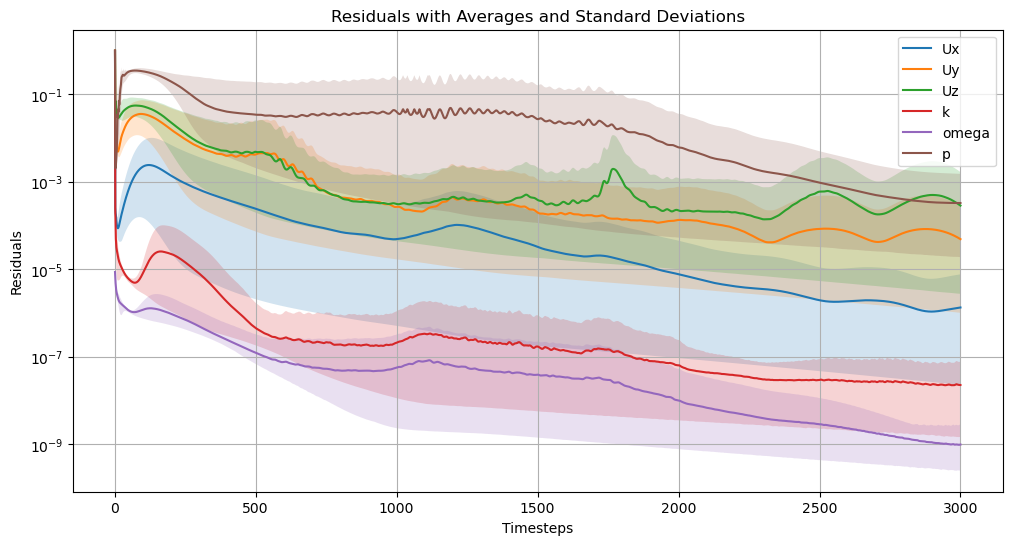

In [26]:
# List of your DataFrames
df_list = [dfs[240], dfs[340], dfs[440], dfs[540], dfs[640], dfs[740]]

# Assuming all DataFrames have the same structure and column names
time = dfs[740]['Time']  # Use the 'Time' column from one of the DataFrames

# Initialize a dictionary to hold aggregated data
aggregated = {}

# Aggregate data: compute mean and std for each column
for col in dfs[740].columns:
    if "initial" in col:
        # Extract the values for this column across all DataFrames
        data = np.array([df[col] for df in df_list])
        
        # Compute mean and standard deviation
        aggregated[col] = {
            "mean": np.mean(data, axis=0),
            "min": np.min(data, axis=0),
            "max": np.max(data, axis=0)
        }

# Plot the results
plt.figure(figsize=(12, 6))
plt.yscale('log')
plt.xlabel('Timesteps')
plt.ylabel('Residuals')

for col, stats in aggregated.items():
    mean = stats["mean"]
    Min = stats["min"]
    Max = stats["max"]
    
    # Plot the mean as a solid line
    plt.plot(time, mean, label=col.replace('_initial', ''))
    
    # Fill between -std and +std
    plt.fill_between(time, Min , Max, alpha=0.2)

plt.legend()
plt.title('Residuals with Averages and Standard Deviations')
plt.grid(True)
plt.show()

In [27]:
import pyVista as pv

ModuleNotFoundError: No module named 'pyVista'